# Clasificador de imágenes

### Autor: Roberto Maeso Benito
Junio 2021

Nota: tal y como se realizó en clase, se recomienda abrir este notebook con Google Colab para poder correrlo con GPU.



# Clasificador usando datos de Mnist Fashion
Se trabaja con la base de datos utilizada en clase Minist Fashion (https://www.tensorflow.org/datasets/catalog/fashion_mnist), que cuenta con datos de prendas que se separan en 10 tipos. El objetivo de esta sección es superar el 0.90 de precisión en el entrenamiento y el 0.88 en el test.

### Importamos librerias

In [2]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

2.5.0


### Lectura de la base de datos y visualización

La base de datos de moda Fashion MNIST está disponible directamente en el API de tf.keras. 
Se carga de la siguiente manera: al cargar los datos se crean las variables con las imágenes de entrenamiento y sus respectivo labels, y lo mismo para los datos de testeo. 

In [3]:
mnist = tf.keras.datasets.fashion_mnist

In [4]:
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


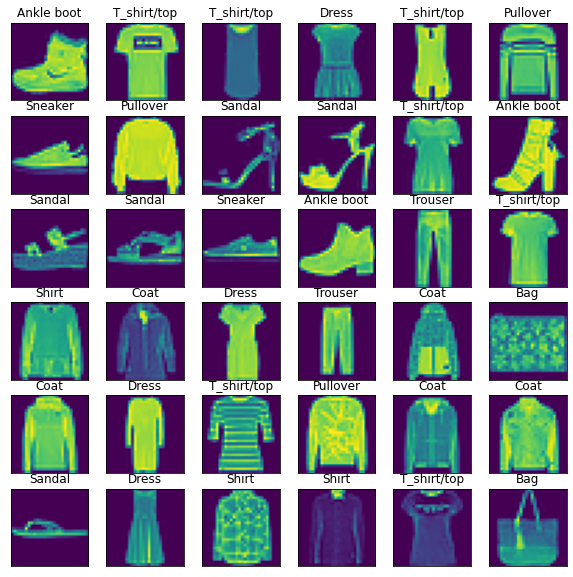

In [5]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i].reshape((28,28)))
    label_index = int(training_labels[i])
    plt.title(class_names[label_index])
plt.show()

### Data-preprocesing
Antes de la modelización procedemos a normalizar los valores entre 0 y 1. Dado que los pixeles van de 0 a 255, dividimos por 255.

In [6]:
image_rows = 28
image_cols = 28
image_shape = (image_rows,image_cols,1) 

In [7]:
training_images  = training_images / 255.0
test_images = test_images / 255.0

In [8]:
training_images = training_images.reshape(training_images.shape[0],*image_shape)
test_images = test_images.reshape(test_images.shape[0],*image_shape)

Tenemos dos grupos, training y test. En el primero iremos mejorando el modelo y en el segundo testearemos el modelo con datos nuevos

### Modelización - Convolutional Neuronal Network

In [9]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

Primero de todo definimos con una función el modelo que vamos a utilizar. Incluimos el compile del modelo, selecionando la función de pérdida. Dado que se trata de un multiclass problem utilizamos sparse_categorical_crossentropy. Para la optimización usamos Adam optimizer, con un learning rate de 0.001. Normalmente este learning rate se suele situar entre 0.001-0.1

Las funciones que se han desarrollado para cada modelo permiten ajustar el learning rate, el número de capas (no las convolucionales) y el dropout de estas capas.

In [95]:
def model_mnist(dense_layers=32,dropout_layers=0.25, learning_rate=0.001):
  model=Sequential()
  model.add(Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = image_shape)) 
  # Aplicamos filtros a la matriz de imágenes para generar los denominamos feature maps (normalmente se usan al principio 32 filter maps)
  # Utilizamos la función ReLU para recoger la no linealidad de los datos
  model.add(MaxPooling2D(pool_size=2))
  # Aplicamos un downsampling en cada feature map que hemos generado con el Conv2D
  model.add(Dropout(dropout_layers)) 
  # Aplicamos un dropout por defecto de 0.25 - regularización - para asegurar que el modelo no pasa siempre por las mismas neuronas 
  model.add(Flatten())
  # Hacemos un flatten out the layers, que se suele utilizar siempre para ímagenes
  model.add(Dense(dense_layers,activation='relu'))
  model.add(Dense(len(class_names),activation = 'softmax')) # ouput de 10 categorías de imágenes
  # compile the model
  model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=learning_rate),metrics =['accuracy'])
  return model

A continuación definimos un batch_size de 4096 y número de epocas de 80 (con google colab y dado que estamos usando la GPU podemos computar este modelo de forma relativamente rápida).

In [96]:
batch_size = 4096
epochs = 80

In [97]:
model_mnist=model_mnist()
history = model_mnist.fit(
    training_images,
    training_labels,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(test_images, test_labels),
)

Epoch 1/80
15/15 [==============================] - 1s 63ms/step - loss: 1.6338 - accuracy: 0.5133 - val_loss: 0.9880 - val_accuracy: 0.6953
Epoch 2/80
15/15 [==============================] - 1s 51ms/step - loss: 0.7641 - accuracy: 0.7517 - val_loss: 0.6340 - val_accuracy: 0.7779
Epoch 3/80
15/15 [==============================] - 1s 50ms/step - loss: 0.5812 - accuracy: 0.7963 - val_loss: 0.5467 - val_accuracy: 0.8120
Epoch 4/80
15/15 [==============================] - 1s 49ms/step - loss: 0.5105 - accuracy: 0.8234 - val_loss: 0.4966 - val_accuracy: 0.8272
Epoch 5/80
15/15 [==============================] - 1s 50ms/step - loss: 0.4687 - accuracy: 0.8384 - val_loss: 0.4651 - val_accuracy: 0.8381
Epoch 6/80
15/15 [==============================] - 1s 49ms/step - loss: 0.4424 - accuracy: 0.8472 - val_loss: 0.4373 - val_accuracy: 0.8488
Epoch 7/80
15/15 [==============================] - 1s 50ms/step - loss: 0.4203 - accuracy: 0.8546 - val_loss: 0.4207 - val_accuracy: 0.8522
Epoch 8/80
15

Graficamos la precisión del entrenamiento y la test para entender mejor el proceso seguido por el modelo.

Text(0.5, 1.0, 'Train - Accuracy')

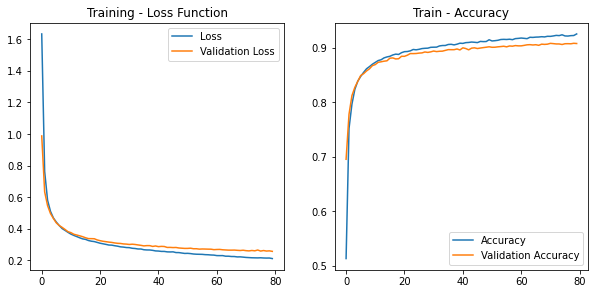

In [98]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

### Resultados del modelo

In [99]:
results = model_mnist.evaluate(test_images,test_labels,verbose=0)
print('Train Accuracy : {:.4f}'.format(history.history['accuracy'][epochs-1]))
print('Test Accuracy : {:.4f}'.format(results[1]))

Train Accuracy : 0.9251
Test Accuracy : 0.9075


Los resultados del modelo muestran una precisión del 91% en test y del 92% en train. A continuación se muestran los resultados del modelo para cada una de las 10 clases/ tipologías de imágenes.

In [100]:
# Predicciones para cada clase
predicted_classes = model_mnist.predict_classes(test_images)
# Importamos classification_report de sklearn para identificar la precisión obtenida con cada categoría de imágenes
from sklearn.metrics import classification_report
classes_names = ["Class {}".format(i) for i in range(10)] # 10 clases
print(classification_report(test_labels, predicted_classes, target_names=classes_names))

              precision    recall  f1-score   support

     Class 0       0.84      0.85      0.85      1000
     Class 1       0.99      0.97      0.98      1000
     Class 2       0.86      0.84      0.85      1000
     Class 3       0.90      0.92      0.91      1000
     Class 4       0.86      0.87      0.86      1000
     Class 5       0.98      0.97      0.98      1000
     Class 6       0.74      0.73      0.74      1000
     Class 7       0.95      0.98      0.96      1000
     Class 8       0.98      0.98      0.98      1000
     Class 9       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



Tal y como se puede apreciar, el modelo alcanza la menor precisión a la hora de clasificar las imágenes de la categoría 6 (72%). En el resto de imágenes la precisión del modelo es bastante elevada, superando siempre ese 85%. 

# Clasificador usando los datos de CIFAR-10

Se trabaja con la base de datos utilizada CIFAR-10 (https://www.tensorflow.org/datasets/catalog/cifar10), que cuenta con datos de 60000 32x32 imágenes de color de 10 clases diferentes, con 6000 imágenes por categoría. El objetivo de esta sección es superar Superar el 0.90 de precisión en el entrenamiento y el 0.74 en el test. El punto restante se obtiene según los resultados obtenidos en estricto orden, tal y como se haría en una competición de Kaggle.

###   Lectura de datos y visualización


Cargamos las librerias que vamos utilizar para este dataset

In [36]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
import os

Dado que se usa una estructura de CNN más avanzado, se proceden a cargar las siguientes librerias concretas

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Definimos el nombre de las categorías de las imágenes y cargamos el dataset directamente de keras

In [60]:
class_names = ['avión', 'coche', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']
# Cargamos el dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Graficamos para ver el número de imagenes que existen de cada una de las categorías

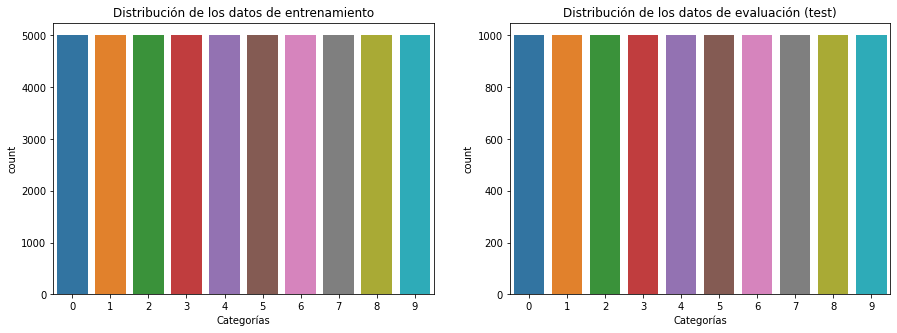

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Plot con los datos de entrenamiento
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribución de los datos de entrenamiento')
axs[0].set_xlabel('Categorías')
# Plot con los datos de test
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribución de los datos de evaluación (test)')
axs[1].set_xlabel('Categorías')
plt.show()

Como podemos observar el dataset está balanceado, existiendo el mismo número de imágenes para las distintas categorías

### Data-preproccesing 

Antes de comenzar con la modelización procedemos, al igual que hicimos con el anterior dataset a normalizar los datos y convertir las vectores a matrices de 0/1 (one-hot encoding)

In [62]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test = X_test/255

In [63]:
# Realizamos one hot encoding en la columna de categorías de las imágenes
from tensorflow.keras.utils import to_categorical
num_classes=len(class_names)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Modelo base - Convolutional Neuronal Network

En este apartado se define un modelo de CNN donde se busca conseguir la máxima precisión posible, superando el 90% en los datos de entrenamiento e intentando conseguir la máxima precisión posible en los datos de validación. 
Para ello, se han utilizado principalmente dos modelos. Un primer modelo (basemodel) y un segundo modelo (finalmodel) donde se incluyen aspectos ampliamente utilizados en las arquitecturas avanzadas de Kaggle con image augmentation o batch Normalization. 

En el basemodel, se ha probado primero sin regularizar el modelo y posteriormente se ha añadido dropout tanto en las capas convolucionales somo en las normales.

**Modelo base inicial**: Se utiliza un modelo con 3 capas convolucionales con 32,64 y 128 filtros cada una, respectivamente. Asimismo, se usan unas dimensiones de los inputs de partida de 32x32x3. De forma inicial, y aunque estos modelos suelen experimentar un overfitting importante, no se incluye un dropout en cada capa convolucional y en las capas normales.
La función generada con este modelo permite elegir si se desesea incluir dropout, y otra serie de parámetros como el learning rate, las dense layers, y los niveles de dropout para las capas convolucionales y las dense layers.

In [115]:
def basemodel(dense_layers=128,dropout_layers=0.3,learning_rate=0.001, dropout=True, firstdropout_cnn=0.2):

  ##### FUNCIÓN PARA GENERAR UN CNN PARA CLASIFICAR IMÁGENES ################
  # Se realizan 3 capas convolucionales, donde en cada una de las capas se realiza el 
  # un downsampling en cada feature map que hemos generado con el Conv2D (las feature maps generadas se incrementan, pasando de 32 a 54 y por último a 128)
  # y se un incluye un dropout que también va aumentando desde un 0.1 en la primera capa hasta llegar a 0.4, en la última
  # Se usa una función de activación ReLU con un inicializador de pesos 'he_uniform' (para el output la función en softmax ya que es un problema de clasificación)

  model = Sequential()

  # Primera capa convolutional
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPool2D((2, 2)))
  if dropout==True:
    model.add(Dropout(firstdropout_cnn))

  # Segunda capa convolutional
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPool2D((2, 2)))
  if dropout==True:
    model.add(Dropout(firstdropout_cnn + 0.1))

  # Tercera capa convolutional
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPool2D((2, 2)))
  if dropout==True:
    model.add(Dropout(firstdropout_cnn + 0.1))

  # completamos el clasificador, añadiendo el flatten, las capas, el dropout y la función de activación final con las 
  # 10 categorías de nuestras imágenes
  model.add(Flatten()) 
  model.add(Dense(dense_layers, activation='relu', kernel_initializer='he_uniform'))
  if dropout==True:
    model.add(Dropout(dropout_layers))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [107]:
# Calculamos la precisión en train y test con la estructura de la CNN que hemos definido anteriormente
basemodel = basemodel(dropout=False) # primero no incluimos dropout
history_basemodel=basemodel.fit(X_train,
                                y_train,
                                epochs=50,
                                validation_data=(X_test,y_test))

Epoch 1/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4210 - accuracy: 0.4846 - val_loss: 1.0714 - val_accuracy: 0.6270
Epoch 2/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9004 - accuracy: 0.6839 - val_loss: 0.8939 - val_accuracy: 0.6946
Epoch 3/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7076 - accuracy: 0.7517 - val_loss: 0.7748 - val_accuracy: 0.7373
Epoch 4/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5772 - accuracy: 0.7993 - val_loss: 0.7237 - val_accuracy: 0.7599
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4775 - accuracy: 0.8327 - val_loss: 0.7131 - val_accuracy: 0.7673
Epoch 6/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3921 - accuracy: 0.8604 - val_loss: 0.7346 - val_accuracy: 0.7647
Epoch 7/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3264 - accuracy: 0.8859 - val_loss: 0.8359 - val_accuracy:

A continuación graficamos los resultados e imprimimos la métrica de precisión para los datos de entrenamiento y test

Text(0.5, 1.0, 'Train - Accuracy')

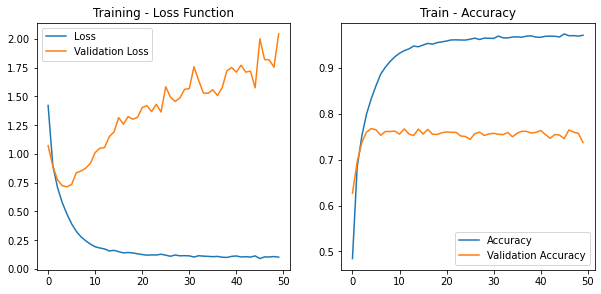

In [108]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_basemodel.history['loss'], label='Loss')
plt.plot(history_basemodel.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_basemodel.history['accuracy'], label='Accuracy')
plt.plot(history_basemodel.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [109]:
results_basemodel = basemodel.evaluate(X_test, y_test,verbose=0)
print('Train Accuracy Modelo CNN base : {:.4f}'.format(history_basemodel.history['accuracy'][49]))
print('Test Accuracy Modelo CNN base : {:.4f}'.format(results_basemodel [1]))

Train Accuracy Modelo CNN base : 0.9704
Test Accuracy Modelo CNN base : 0.7369


Como podemos ver hemos superado el 90% de precisión en los datos de entrenamiento pero en test los resultados empeoran significativamente. Dado que estamos ante un caso claro de overffiting vamos a tratar de reducir la precisión en train para poder ganar mayor generalización cuando el modelo recibe nuevos datos. Uno de los métodos para hacer esto es introducir Dropout en el modelo. Es decir, desactivar de forma aleatoria un tanto por ciento de las neurones para que el modelo no pase siempre por las mismas neuronas de cara a obtener siempre los resultados. De esta manera, y basandonos en la función creada con este modelo, incluimos ahora el dropout, tanto en las capas convolutionales como en el resto.

In [116]:
basemodel_withdropout = basemodel() # incluimos dropout ya que esta por defecto en la función creada
history_basemodel_withdropout=basemodel_withdropout.fit(X_train,
                                y_train,
                                epochs=50,
                                validation_data=(X_test,y_test))

Epoch 1/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7998 - accuracy: 0.3269 - val_loss: 1.3371 - val_accuracy: 0.5144
Epoch 2/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3162 - accuracy: 0.5284 - val_loss: 1.1149 - val_accuracy: 0.5940
Epoch 3/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1307 - accuracy: 0.5964 - val_loss: 0.9640 - val_accuracy: 0.6595
Epoch 4/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0359 - accuracy: 0.6361 - val_loss: 0.9029 - val_accuracy: 0.6828
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9621 - accuracy: 0.6646 - val_loss: 0.8574 - val_accuracy: 0.6993
Epoch 6/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9043 - accuracy: 0.6850 - val_loss: 0.7993 - val_accuracy: 0.7189
Epoch 7/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8742 - accuracy: 0.6997 - val_loss: 0.7765 - val_accuracy

El modelo con dropout parece eliminar ese claro overfitting que teniamos en un inicio. A continuación pasamos a presentar los resultados de este segundo modelo base con dropout.

## Resultados y evaluación del modelo base

Gráficamos la evolución que ha tenido la precisión y el error tanto en los datos de entrenamiento como de test para las 50 epocas definidas

Text(0.5, 1.0, 'Train - Accuracy')

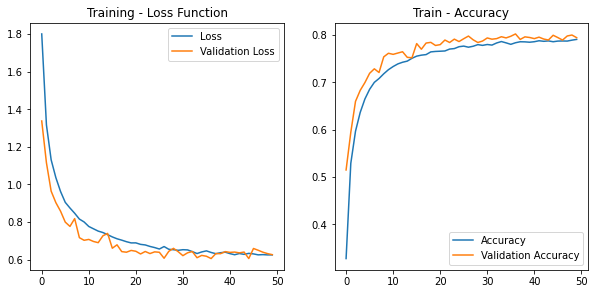

In [117]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_basemodel_withdropout.history['loss'], label='Loss')
plt.plot(history_basemodel_withdropout.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_basemodel_withdropout.history['accuracy'], label='Accuracy')
plt.plot(history_basemodel_withdropout.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

 A continuación mostramos los resultados obtenidos, tanto en train como en test:

In [118]:
results_basemodel_withdropout = basemodel_withdropout.evaluate(X_test, y_test,verbose=0)
print('Train Accuracy Modelo CNN base : {:.4f}'.format(history_basemodel_withdropout.history['accuracy'][49]))
print('Test Accuracy Modelo CNN base : {:.4f}'.format(results_basemodel_withdropout [1]))

Train Accuracy Modelo CNN base : 0.7906
Test Accuracy Modelo CNN base : 0.7943


Tal y como se realizó en el primer ejercicio, a continuación se muestran los resultados obtenidos para cada categoría de imágenes:

In [119]:
# Hacemos las predicciones
pred = basemodel_withdropout.predict(X_test)
# Convertimos las predicciones a variables binarias
Y_pred_classes = np.argmax(pred, axis=1) 
# Hacemos lo mismo con las true labels
Y_true = np.argmax(y_test, axis=1)
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.91      0.92      0.92      1000
           2       0.74      0.68      0.71      1000
           3       0.60      0.66      0.63      1000
           4       0.75      0.77      0.76      1000
           5       0.74      0.68      0.71      1000
           6       0.74      0.91      0.81      1000
           7       0.92      0.77      0.84      1000
           8       0.92      0.85      0.88      1000
           9       0.86      0.92      0.89      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



Dado que los niveles obtenidos de precisión son reducidos a continuación se realiza un modelo avanzado de CNN partiendo del modelo base realizado

## Modelo final - Convolutional Neuronal Network con batch  normalization e image augmentation

Partiendo del modelo base se procede a realizar un nuevo modelo en el que se incluyen dos aspectos claves en la estructura de la red neuronal. Por un lado, la normalización de batch, que nos permite entrenar más al modelo, haciendolo más estable y ajustando así el learning rate. Por otro lado, también se usa image augmentation, que nos permite generar más imagenes para que nuestra red aprenda y mejore en las distintas iteracciones.

In [103]:
def finalmodel(dense_layers=128,dropout_layers=0.45,learning_rate=0.001, 
               dropout=True, firstdropout_cnn=0.15, batch_norm=True):

  ##### FUNCIÓN CON BATCH NORMALIZATION PARA GENERAR UNA CNN PARA CLASIFICAR IMÁGENES ################
  # Se parte de la CNN anterior y se incluye una batch normalization en cada una de las capas convolucionales

  model = Sequential()

  # Primera estructura de la capa convolucional
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  if batch_norm==True:
    model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  if batch_norm==True:
    model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  if dropout==True:
    model.add(Dropout(firstdropout_cnn))

  # Segunda estructura de la capa convolucional
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  if batch_norm==True:
    model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  if batch_norm==True:
    model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  if dropout==True:
    model.add(Dropout(firstdropout_cnn + 0.1))

  # Tercera estructura de la capa convolucional
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  if batch_norm==True:
    model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  if batch_norm==True:
    model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  if dropout==True:
    model.add(Dropout(firstdropout_cnn + 0.15))

  # completamos el clasificador, incluyendo el BatchNormalization
  model.add(Flatten())
  model.add(Dense(dense_layers, activation='relu', kernel_initializer='he_uniform'))
  if batch_norm==True:
    model.add(BatchNormalization())
  if dropout==True:
    model.add(Dropout(dropout_layers))
  model.add(Dense(num_classes, activation='softmax'))

  # compilamos el modelo
  model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

Una vez definida la función de la nueva CNN con batch normalización, aplicamos el concepto de image augmentation para poder generar más imágenes con las que poder seguir entrenando el modelo. En concreto,generamos las imagenes rotandolas a una posición horizontal para ver como actua nuestro modelo.

In [104]:
generador_imagenes = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,rotation_range=20)
image_augmentation = generador_imagenes.flow(X_train,y_train)

In [ ]:
pasos = int(X_train.shape[0] / 64)
finalmodel = finalmodel()
history_finalmodel=finalmodel.fit_generator(image_augmentation, # incluimos las imagenes generadas anteriormente
                                            epochs=150, # aumentamos el número de epocas ya que ahora tenemos un número más elevado de imagenes sobre las que entrenar nuestro modelo
                                            steps_per_epoch=pasos, # pasos por cada época que vamos a predecir el modelo
                                            validation_data=(X_test,y_test))

Epoch 1/150
781/781 [==============================] - 17s 20ms/step - loss: 1.8467 - accuracy: 0.3570 - val_loss: 1.4323 - val_accuracy: 0.4809
Epoch 2/150
781/781 [==============================] - 15s 19ms/step - loss: 1.4443 - accuracy: 0.4704 - val_loss: 1.2455 - val_accuracy: 0.5421
Epoch 3/150
781/781 [==============================] - 15s 20ms/step - loss: 1.2662 - accuracy: 0.5420 - val_loss: 1.2601 - val_accuracy: 0.5673
Epoch 4/150
781/781 [==============================] - 15s 19ms/step - loss: 1.1460 - accuracy: 0.5929 - val_loss: 1.0625 - val_accuracy: 0.6276
Epoch 5/150
781/781 [==============================] - 15s 19ms/step - loss: 1.0752 - accuracy: 0.6220 - val_loss: 1.1087 - val_accuracy: 0.6270
Epoch 6/150
781/781 [==============================] - 15s 20ms/step - loss: 1.0039 - accuracy: 0.6447 - val_loss: 0.9258 - val_accuracy: 0.6719
Epoch 7/150
781/781 [==============================] - 15s 19ms/step - loss: 0.9589 - accuracy: 0.6657 - val_loss: 0.9682 - val_ac

## Evaluación y resultados del modelo final

Parece que nuestro modelo ha mejorado significativamente. Procedemos a graficar la precisión y el error en los datos de entrenamiento y test

Text(0.5, 1.0, 'Train - Accuracy')

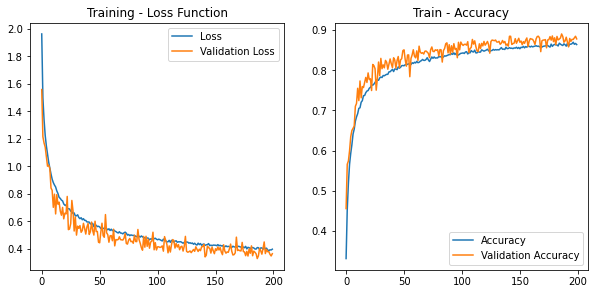

In [89]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_finalmodel.history['loss'], label='Loss')
plt.plot(history_finalmodel.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_finalmodel.history['accuracy'], label='Accuracy')
plt.plot(history_finalmodel.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

Al igual que antes, generamos nuestra matriz de confusión

In [93]:
results_finalmodel = finalmodel.evaluate(X_test, y_test,verbose=0)
print('Train Accuracy Modelo CNN final : {:.4f}'.format(history_finalmodel.history['accuracy'][199]))
print('Test Accuracy Modelo CNN final : {:.4f}'.format(results_finalmodel[1]))

Train Accuracy Modelo CNN final : 0.8638
Test Accuracy Modelo CNN final : 0.8779


In [94]:
# Hacemos las predicciones
pred_finalmodel = finalmodel.predict(X_test)
# Convertimos las predicciones a variables binarias
Y_pred_classes_final = np.argmax(pred_finalmodel, axis=1) 
# Hacemos lo mismo con las true labels
Y_true_final = np.argmax(y_test, axis=1)
print(classification_report(Y_true_final, Y_pred_classes_final))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1000
           1       0.89      0.97      0.93      1000
           2       0.90      0.80      0.85      1000
           3       0.86      0.70      0.77      1000
           4       0.84      0.90      0.87      1000
           5       0.88      0.78      0.83      1000
           6       0.85      0.96      0.90      1000
           7       0.83      0.95      0.89      1000
           8       0.96      0.89      0.92      1000
           9       0.91      0.93      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



**Conclusión**

El último modelo presentado permite obtener los mejores resultados sobre los datos de validación. Por este motivo, se define este último modelo (finalmodel) como el utilizado para la competición (precisión del 88% sobre test).

Este modelo incorpora dos aspectos clave que recogen la mayoría de arquitecturas avanzadas de kaggle: la batch normalization y la generación de imagenes (image augmentation). Adicionalmente, se ha incluido un dropout y los feature maps progresivos, que aumentan desde la primera capa convolucional hasta la última. De cara a futuros trabajos, se podrian probar variantes de este modelo con diferentes batch sizes o incluso con modelos más asociados con reinforment learning. 